# Tweets


---



# Load the data

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 85.1 MB/s eta 0:00:00


In [ ]:
# Load the library
from google.colab import drive
import os
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from transformers import BertTokenizerFast
from transformers import TFBertModel
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
drive.mount('/content/drive')
path = "Please_Type_Your_File_Path"

# Train
train_df = pd.read_csv(os.path.join(path, "Tweets_train.csv"))
# Validate
validate_df = pd.read_csv(os.path.join(path, "Tweets_dev.csv"))
# Test
test_df = pd.read_csv(os.path.join(path, "New_Tweets_test-1.csv"))

Mounted at /content/drive


# Explore the data

In [ ]:
train_df

,tweet_id,text,airline_sentiment
0,569179849518161920,@united you're good. Thank you!,positive
1,569835751275433984,"@AmericanAir way to ruin a vacation, my brothe...",negative
2,568588936852799488,@JetBlue yes thankfully! Catering just got her...,positive
3,569525116725567491,@USAirways The automated message isn't helpful...,negative
4,568807823187976193,@JetBlue I'm #MakingLoveOutofNothingAtAll on m...,positive
...,...,...,...
11853,570123872168574976,"@AmericanAir will not help us on the phone, at...",negative
11854,570063683256242177,@USAirways has the worst customer service line...,negative
11855,568032524749942784,@USAirways grades for this trip:\n\nFlight tim...,negative
11856,569705813142409217,@united Thanks for the vague canned response t...,negative


In [ ]:
print(train_df['airline_sentiment'].value_counts())
print(validate_df['airline_sentiment'].value_counts())
print(test_df['airline_sentiment'].value_counts())

negative    7434
neutral     2510
positive    1914
Name: airline_sentiment, dtype: int64
negative    826
neutral     279
positive    213
Name: airline_sentiment, dtype: int64
negative    918
neutral     310
positive    236
Name: airline_sentiment, dtype: int64


Text(0, 0.5, 'Number of tweets')

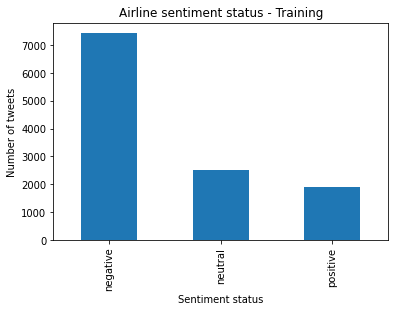

In [ ]:
ax = train_df['airline_sentiment'].value_counts().plot(kind='bar', figsize=(6, 4), title="Airline sentiment status - Training")
ax.set_xlabel("Sentiment status")
ax.set_ylabel("Number of tweets")

Text(0, 0.5, 'Number of tweets')

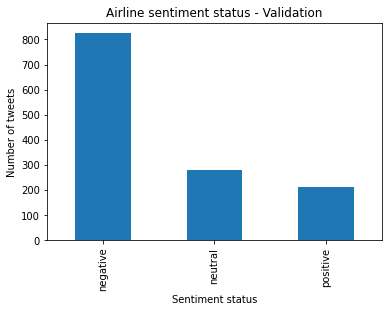

In [ ]:
ax = validate_df['airline_sentiment'].value_counts().plot(kind='bar', figsize=(6, 4), title="Airline sentiment status - Validation")
ax.set_xlabel("Sentiment status")
ax.set_ylabel("Number of tweets")

Text(0, 0.5, 'Number of tweets')

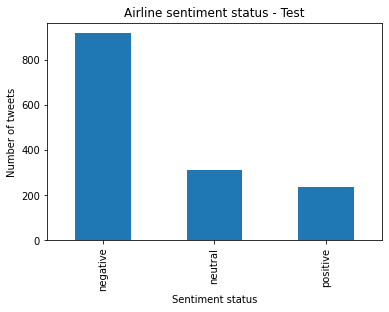

In [ ]:
ax = test_df['airline_sentiment'].value_counts().plot(kind='bar', figsize=(6, 4), title="Airline sentiment status - Test")
ax.set_xlabel("Sentiment status")
ax.set_ylabel("Number of tweets")

# Preprocessing

## Removing unnecessary words

Remove:
- @Account tag (i.e. Airline names)
- Links
- Stopwords



In [ ]:
def filter_tweets(tweet):
  # Remove Account tag and links
  filtered_tweet = re.sub(r"(?:\@|https?\://)\S+", "", tweet)
  # Tokenization
  word_tokens = word_tokenize(filtered_tweet)
  # Convert all in lower case & Remove stopwords
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [token for token in word_tokens if not token.lower() in stop_words]

  return(" ".join(filtered_tokens))

Filter the tweets & Convert sentiment(negative, neutral, positive) into '0,1,2'

In [ ]:
sentiment = ['negative', 'neutral', 'positive']
# Train
train_df['filtered_text'] = train_df['text'].apply(lambda x:filter_tweets(x))
train_df['sentiment'] = train_df['airline_sentiment'].apply(lambda x: sentiment.index(x))
# Validate
validate_df['filtered_text'] = validate_df['text'].apply(lambda x:filter_tweets(x))
validate_df['sentiment'] = validate_df['airline_sentiment'].apply(lambda x: sentiment.index(x))
# Test
test_df['filtered_text'] = test_df['text'].apply(lambda x:filter_tweets(x))
test_df['sentiment'] = test_df['airline_sentiment'].apply(lambda x: sentiment.index(x))

## Balancing the class

Imbalanced dataset

In [ ]:
print(train_df['sentiment'].value_counts())

0    7434
1    2510
2    1914
Name: sentiment, dtype: int64


In [ ]:
ROS = RandomOverSampler()
train_X, train_y = ROS.fit_resample(np.array(train_df['filtered_text']).reshape(-1, 1), np.array(train_df['sentiment']).reshape(-1, 1));
train_df_balanced = pd.DataFrame(list(zip([x[0] for x in train_X], train_y)), columns = ['filtered_text', 'sentiment']);

Balanced dataset

In [ ]:
print(train_df_balanced['sentiment'].value_counts())

2    7434
0    7434
1    7434
Name: sentiment, dtype: int64


In [ ]:
# Train
train_X = train_df_balanced['filtered_text']
train_y = train_df_balanced['sentiment']
# Validate
validate_X = validate_df['filtered_text']
validate_y = validate_df['sentiment']
# Test
test_X = test_df['filtered_text']
test_y = test_df['sentiment']

## One hot encoding

In [ ]:
ohe = preprocessing.OneHotEncoder()
train_y_ohe = ohe.fit_transform(np.array(train_y).reshape(-1, 1)).toarray()
validate_y_ohe = ohe.fit_transform(np.array(validate_y).reshape(-1, 1)).toarray()
test_y_ohe = ohe.fit_transform(np.array(test_y).reshape(-1, 1)).toarray()

# Training Models

## Naive Bayes

### Bag of Words approach

In [ ]:
cv = CountVectorizer()

train_X_cv =  cv.fit_transform(train_X)
validate_X_cv = cv.transform(validate_X)
test_X_cv = cv.transform(test_X)

### TF-IDF

In [ ]:
tf_idf = TfidfTransformer(use_idf=True).fit(train_X_cv)

train_X_tf = tf_idf.transform(train_X_cv)
validate_X_tf = tf_idf.transform(validate_X_cv)
test_X_tf = tf_idf.transform(test_X_cv)

### Multinomial NB

In [ ]:
clf = MultinomialNB()
clf.fit(train_X_tf, train_y)
pred = clf.predict(test_X_tf)

print('\tClassification Report for Multinomial NB:\n\n', classification_report(test_y, pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Multinomial NB:

               precision    recall  f1-score   support

    Negative       0.87      0.86      0.87       918
     Neutral       0.61      0.58      0.59       310
    Positive       0.63      0.71      0.67       236

    accuracy                           0.78      1464
   macro avg       0.71      0.72      0.71      1464
weighted avg       0.78      0.78      0.78      1464



<Figure size 432x288 with 0 Axes>

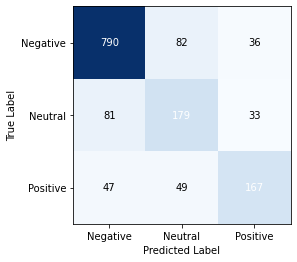

In [ ]:
cm = confusion_matrix(pred, test_y)
plt.figure()
plot_confusion_matrix(cm, cmap=plt.cm.Blues)
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'])
plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## BERT

### Tokenize

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def get_max_token_length(tweets):
  tokens_length = []

  for tweet in tweets.values:
      tokens = tokenizer.encode(tweet, max_length=512, truncation=True)
      tokens_length.append(len(tokens))
      
  max_length = np.max(tokens_length)
  
  return max_length

In [ ]:
max = get_max_token_length(train_df_balanced['filtered_text']) + 10

In [ ]:
def get_ids_and_masks(dataset, max_length) :
    input_ids=[]
    attention_masks=[]

    for data in dataset:
        encoded = tokenizer.encode_plus(data, add_special_tokens=True, max_length=max_length, padding='max_length', return_attention_mask=True)

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    input_ids_final = np.array(input_ids)
    attention_masks_final = np.array(attention_masks)

    return input_ids_final, attention_masks_final

In [ ]:
train_input_ids, train_attention_masks = get_ids_and_masks(train_X, max)
val_input_ids, val_attention_masks = get_ids_and_masks(validate_X, max)
test_input_ids, test_attention_masks = get_ids_and_masks(test_X, max)

### Modelling

In [ ]:
BERT = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def build_model_bert(bert_model, max_length):
    input_ids = tf.keras.Input(shape=(max_length,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_length,), dtype='int32')
    
    embeddings = bert_model([input_ids, attention_masks])[1]
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)

    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [ ]:
model_bert = build_model_bert(BERT, max)
model_bert.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 64,                                          

In [ ]:
history_bert = model_bert.fit([train_input_ids, train_attention_masks], train_y_ohe, validation_data=([val_input_ids, val_attention_masks], validate_y_ohe), epochs=4, batch_size=32)

Epoch 1/4
697/697 [==============================] - 294s 401ms/step - loss: 0.5597 - accuracy: 0.7712 - val_loss: 0.5009 - val_accuracy: 0.8005
Epoch 2/4
697/697 [==============================] - 276s 396ms/step - loss: 0.2928 - accuracy: 0.8964 - val_loss: 0.5458 - val_accuracy: 0.8080
Epoch 3/4
697/697 [==============================] - 276s 396ms/step - loss: 0.1669 - accuracy: 0.9462 - val_loss: 0.6516 - val_accuracy: 0.8080
Epoch 4/4
697/697 [==============================] - 276s 396ms/step - loss: 0.0980 - accuracy: 0.9685 - val_loss: 0.7534 - val_accuracy: 0.8065


### Evaluation

In [ ]:
prediction = model_bert.predict([test_input_ids, test_attention_masks])

46/46 [==============================] - 9s 133ms/step


In [ ]:
pre = np.zeros_like(prediction)
pre[np.arange(len(pre)), prediction.argmax(1)] = 1

print('\tClassification Report for BERT:\n\n', classification_report(test_y_ohe, pre, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.89      0.89      0.89       918
     Neutral       0.64      0.69      0.66       310
    Positive       0.76      0.69      0.72       236

   micro avg       0.81      0.81      0.81      1464
   macro avg       0.76      0.75      0.76      1464
weighted avg       0.82      0.81      0.81      1464
 samples avg       0.81      0.81      0.81      1464



<Figure size 432x288 with 0 Axes>

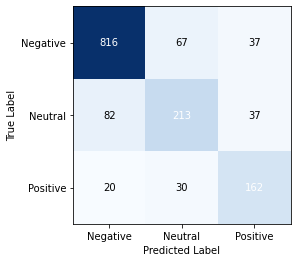

In [ ]:
cm = confusion_matrix(pre.argmax(1), test_y_ohe.argmax(1))
plt.figure()
plot_confusion_matrix(cm, cmap=plt.cm.Blues)
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'])
plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()